# Bookkeeping
## Data quality checks
- naming convention
- completeness
- image dimensions


Each case needs to have the following for both Aqua and Terra
- modis truecolor
- modis falsecolor
- modis cloudfraction
- modis landmask

They're stored in the `data/modis` folder. There should be a file for each case and for each satellite.

## TBD
- Add step to check whether the image dimensions are correct.

In [79]:
import pandas as pd
import numpy as np
import os
import pyproj 

overview_table = pd.read_csv('../data/validation_dataset/validation_dataset.csv', parse_dates=['start_date'])
overview_table['case_number'] = [str(x).zfill(3) for x in overview_table['case_number']]
overview_table.index = [cn + '_' + sat for cn, sat in zip(overview_table['case_number'], overview_table['satellite'])]
overview_table.head()

,case_number,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,...,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,psd_file,floe_obscuration,landfast_obscuration,modis_cloud_error,notes
001_terra,001,baffin_bay,2022-09-11,-91.527525,77.801013,-962500,-912500,9,1.0,0.573,...,yes,daniel,emma,daniel,NaN,yes,heavy,NaN,no,reclassified landfast ice (likely cloud deck)
001_aqua,001,baffin_bay,2022-09-11,-91.527525,77.801013,-962500,-912500,9,1.0,0.573,...,yes,ethan,daniel,daniel,NaN,yes,heavy,NaN,no,reclassified landfast ice (likely cloud deck)
002_terra,002,baffin_bay,2015-03-12,-81.964289,76.057935,-912500,-1212500,3,1.0,0.858,...,no,daniel,emma,NaN,NaN,NaN,NaN,NaN,no,NaN
002_aqua,002,baffin_bay,2015-03-12,-81.964289,76.057935,-912500,-1212500,3,1.0,0.858,...,no,ethan,daniel,NaN,NaN,NaN,NaN,NaN,no,NaN
003_terra,003,baffin_bay,2012-04-19,-79.579288,75.637235,-887500,-1287500,4,1.0,0.873,...,yes,daniel,emma,NaN,NaN,NaN,NaN,heavy,no,NaN


## MODIS

In [68]:
for imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'landmask']:
    for satellite in ['aqua', 'terra']:
        for case, data in overview_table.iterrows():
            fpath = os.path.join('../data/modis/', imtype, 
                              '-'.join([data.case_number,
                                        data.region,
                                        '100km',
                                        data.start_date.strftime('%Y%m%d')]) + '.' + \
                              '.'.join([satellite, imtype, '250m', 'tiff']))
            if not os.path.exists(fpath):
                print(fpath)

## MASIE

In [69]:
for imtype in 'seaice', 'landmask':
    for case, data in overview_table.iterrows():
        fpath = os.path.join('../data/masie/', imtype, 
                          '-'.join([data.case_number,
                                    data.region,
                                    '100km',
                                    data.start_date.strftime('%Y%m%d')]) + '.' + \
                          '.'.join(['masie', imtype, '250m', 'tiff']))
        if not os.path.exists(fpath):
            print(fpath)

# Checking the status of the validation imagery
Validation imagery comes in multiple categories: manually labeled and algorithmic labels. In the former category, we are checking the floe labeling column against the files found in the `binary_floes`, `binary_landmask`, `binary_landfast`, and `labeled_floes` subfolders.

First, we look to see if any images are listed in the data table that are missing from the folder.

If nothing prints, then all the images listed in the table are present.

In [80]:
dataloc = '../data/validation_dataset/'
tbd = []
for row, case in overview_table.iterrows():
    cn = str(case.case_number).zfill(3)
    region = case.region
    start = case.start_date
    satellite = case.satellite

    imtype = 'binary_floes'
    ftype = 'png'
    

    if case.visible_floes == 'yes':
        missing = []
        for imtype in ['binary_floes', 'binary_landfast', 'binary_landmask']:
            fpath = dataloc + imtype + '/' + \
                '-'.join([cn, region, start.strftime('%Y%m%d'), satellite, imtype]) + '.' + ftype
            if case.notnull().fl_analyst:
                if not os.path.isfile(fpath):
                    missing.append(imtype)
            elif imtype == 'binary_floes': # just tabulate the missing ones for binary floes
                tbd.append(row)
        if len(missing) > 0:
            print(cn, satellite, region, ' '.join(missing), case.fl_analyst)

print(len(missing))

168 aqua laptev_sea binary_floes binary_landfast daniel
168 terra laptev_sea binary_floes binary_landfast daniel
0


In [81]:
print(len(tbd))

0


Next, check if any files in the folder aren't in the table.

Labeled floes:

In [82]:
files = [f for f in os.listdir(dataloc + 'labeled_floes') if 'tiff' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = overview_table.loc[((overview_table.case_number == cn) & (overview_table.region == region)) & 
                            (overview_table.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

Labeled landfast:

In [87]:
files = [f for f in os.listdir(dataloc + 'binary_landfast') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = overview_table.loc[((overview_table.case_number == cn) & (overview_table.region == region)) & (overview_table.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

Landmask: These are the cases that haven't had the validation images done yet. Landmask is done automatically so there are more files here than in the other categories.

In [89]:
files = [f for f in os.listdir(dataloc + 'binary_landmask') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = overview_table.loc[((overview_table.case_number == cn) & (overview_table.region == region))
                                & (overview_table.satellite == satellite)]
    if len(row) > 0:
        if row['visible_floes'].values == 'yes':
            if row.isnull()['fl_analyst'].values[0]:
                print(file)
    else:
        print(file, 'Missing from table')

Photoshop file:

In [91]:
files = [f for f in os.listdir(dataloc + 'labeling_psd_files/labeling_done') if 'psd' in f]
files.sort()
for file in files:
    cn = file.split('-')[0]
    if 'aqua' in file:
        satellite == 'aqua'
    else:
        satellite == 'terra'
    
    row = overview_table.loc[(overview_table.case_number == cn) & (overview_table.satellite == satellite)]
    if len(row) > 0:
        if row.notnull()['fl_analyst'].values[0]:
            if row.isnull()['psd_file'].values[0]:
                print(file)
    else:
        print(file, 'Missing from table')

# TBD

Number of floes needing review, metadata needed, and metadata review needed

In [92]:
print('Metadata needed:', len(overview_table.loc[overview_table.qa_analyst.isnull()]))
print('Metadata review needed:', len(overview_table.loc[overview_table.qa_analyst.notnull()
                                     & overview_table.qa_reviewer.isnull()]))

print('Total images w/ floes:', len(overview_table.loc[(overview_table.visible_floes == 'yes'),:]))
print('Total labeled images:', len(overview_table.loc[(overview_table.visible_floes == 'yes')
                                   & overview_table.fl_analyst.notnull(),:]))
print('Images remaining:', len(overview_table.loc[((overview_table.visible_floes == 'yes')) 
                               & (overview_table.fl_analyst.isnull()),:]))
print('Floe labeling review needed:', len(overview_table.loc[overview_table.fl_analyst.notnull()
                                          & overview_table.fl_reviewer.isnull()]))

Metadata needed: 0
Metadata review needed: 0
Total images w/ floes: 224
Total labeled images: 224
Images remaining: 0
Floe labeling review needed: 197


Remaining images to process by region:

In [93]:
overview_table.loc[(((overview_table.visible_floes == 'yes')) & (overview_table.fl_analyst.isnull())),
['case_number', 'region']].groupby('region').count()

,case_number
region,


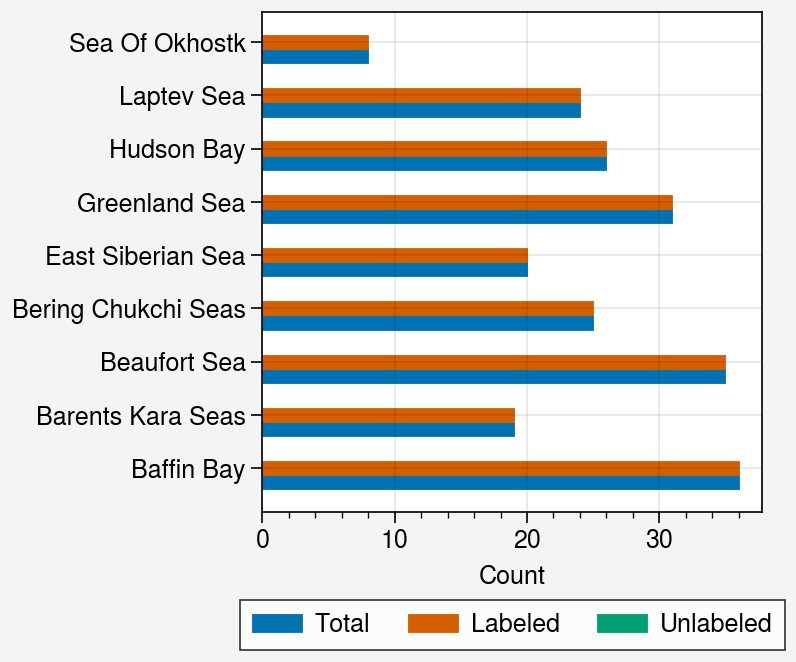

In [94]:
import proplot as pplt
data = overview_table.copy()
total_to_label = data.loc[data.visible_floes == 'yes'].groupby('region').count()['case_number']
total_labeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.notnull(),:].groupby('region').count()['case_number']
total_unlabeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.isnull(),:].groupby('region').count()['case_number']
df = pd.DataFrame({'Total': total_to_label, 'Labeled': total_labeled, 'Unlabeled': total_unlabeled})
df.index = [x.replace('_', ' ').title() for x in df.index]
fig, ax = pplt.subplots()
ax.barh(df)
ax.format(xlabel='Count')
ax.legend(loc='b')
fig.save('../figures/labeling_progress_chart.png', dpi=300)

In [95]:
df.fillna(0)

,Total,Labeled,Unlabeled
Baffin Bay,36,36,0.0
Barents Kara Seas,19,19,0.0
Beaufort Sea,35,35,0.0
Bering Chukchi Seas,25,25,0.0
East Siberian Sea,20,20,0.0
Greenland Sea,31,31,0.0
Hudson Bay,26,26,0.0
Laptev Sea,24,24,0.0
Sea Of Okhostk,8,8,0.0


In [96]:
unlabeled = overview_table.loc[(overview_table.visible_floes == 'yes') & overview_table.fl_analyst.isnull(),:]
for row, data in unlabeled.iterrows():
    psd_name = '-'.join([data.case_number, data.region, data.start_date.strftime('%Y%m%d'), data.satellite, 'labeling_psd'])
    if not os.path.exists('../data/validation_dataset/labeling_psd_files/labeling_psd_templates/' + psd_name + '.psd'):
        print(psd_name)

In [97]:
unlabeled = data.loc[(data.region == 'hudson_bay') & (data.fl_analyst.isnull() & (data.visible_sea_ice == 'yes'))]

In [98]:
data.columns

Index(['case_number', 'region', 'start_date', 'center_lon', 'center_lat',
       'center_x', 'center_y', 'month', 'sea_ice_fraction',
       'mean_sea_ice_concentration', 'init_case_number', 'satellite',
       'visible_sea_ice', 'visible_landfast_ice', 'visible_floes',
       'visible_water', 'cloud_fraction_manual', 'cloud_category_manual',
       'artifacts', 'qa_analyst', 'qa_reviewer', 'fl_analyst', 'fl_reviewer',
       'psd_file', 'floe_obscuration', 'landfast_obscuration',
       'modis_cloud_error', 'notes'],
      dtype='object')

## Additional image labeling tasks
* 60 images left to do the floe labeling - that's about 5 hours of work
* Labeling all landfast ice
* Labeling ice/water pixels

In [99]:
total_to_label = data.loc[data.visible_landfast_ice == 'yes'].groupby('region').count()['case_number']
total_labeled = data.loc[(data.visible_landfast_ice == 'yes') & data.fl_analyst.notnull(),:].groupby('region').count()['case_number']
total_unlabeled = data.loc[(data.visible_landfast_ice == 'yes') & (data.fl_analyst.isnull() & (data.visible_floes == 'no')),:].groupby('region').count()['case_number']
df = pd.DataFrame({'Total': total_to_label, 'Labeled': total_labeled, 'Unlabeled': total_unlabeled})
df.index = [x.replace('_', ' ').title() for x in df.index]
df.fillna(0)

,Total,Labeled,Unlabeled
Baffin Bay,18,14,4.0
Barents Kara Seas,6,6,0.0
Beaufort Sea,16,14,2.0
Bering Chukchi Seas,9,5,4.0
East Siberian Sea,16,10,6.0
Greenland Sea,14,12,2.0
Hudson Bay,18,12,6.0
Laptev Sea,14,12,2.0
Sea Of Okhostk,8,4,4.0


In [100]:
df['Unlabeled'].sum()


30.0

In [105]:
for row, data in data.loc[(data.visible_landfast_ice == 'yes') & (data.fl_analyst.isnull() & (data.visible_floes == 'no')),:].iterrows():
    cn = data.case_number
    region = data.region
    date = data.start_date.strftime('%Y%m%d')
    satellite = data.satellite
    path = "../data/validation_dataset/labeling_psd_files/labeling_psd_templates/"
    fname = '-'.join([cn, region, date, satellite, 'labeling_psd.psd'])
    ! cp $path{'psd_template.psd'} $path$fname

There are 30 images with visible landfast ice that we can add.

A consideration:
* In the final dataset, should we include blank images? Or only masks where the data actually exist?
* If we wrap up each image in a netcdf file, or h5 file, then we can have a layer for each label type that is allowed to be empty

In [101]:
total_to_label = data.loc[data.visible_sea_ice == 'yes'].groupby('region').count()['case_number']
total_labeled = data.loc[(data.visible_sea_ice == 'yes') & data.fl_analyst.notnull(),:].groupby('region').count()['case_number']
total_unlabeled = data.loc[(data.visible_sea_ice == 'yes') & data.fl_analyst.isnull(),:].groupby('region').count()['case_number']
df = pd.DataFrame({'Total': total_to_label, 'Labeled': total_labeled, 'Unlabeled': total_unlabeled})
df.index = [x.replace('_', ' ').title() for x in df.index]
print(df['Unlabeled'].sum())
df['Total'].sum()

81


308

/opt/miniconda3/envs/calval/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


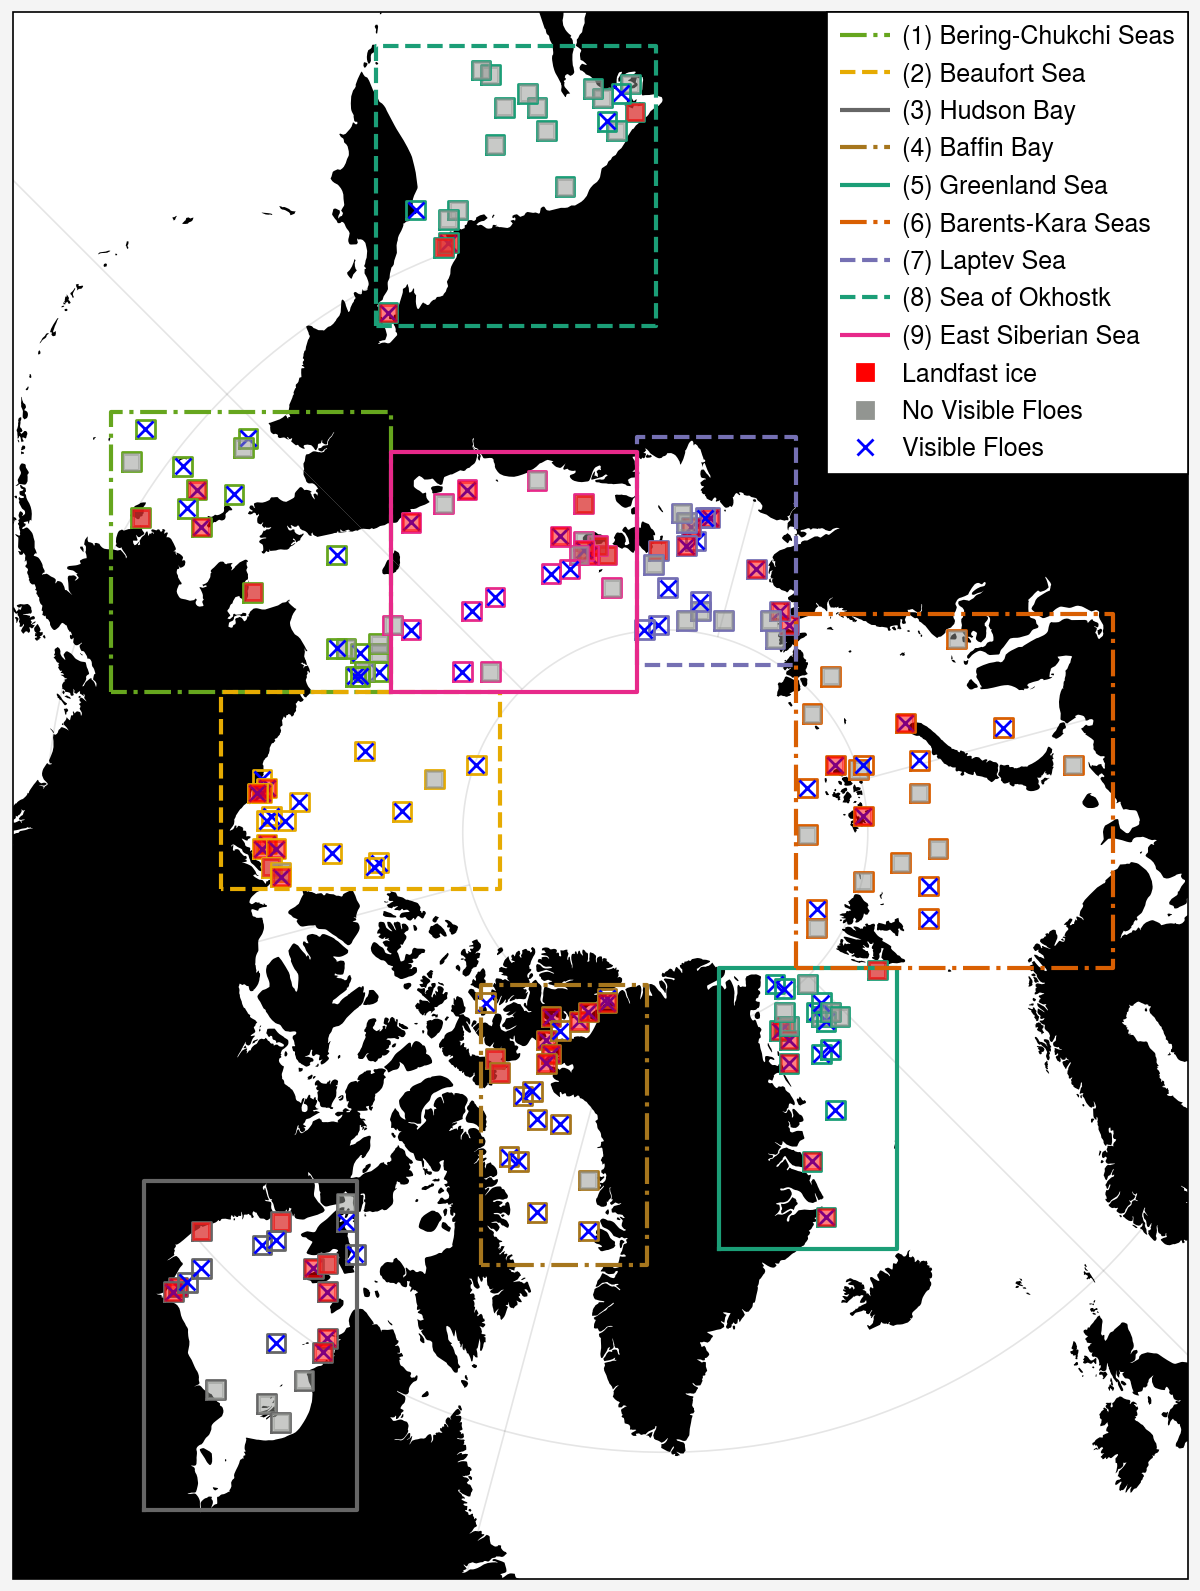

In [111]:
import proplot as pplt
import cartopy.crs as ccrs

df = pd.read_csv('../data/validation_dataset/validation_dataset.csv')
df = df.loc[df.satellite=='aqua']
df.index = [str(x).zfill(3) for x in df.case_number]

regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
linestyles = {region: ls for region, ls in zip(regions.index,
                        ['-', '-.', '--', '-', '-.', '--', '-.', '-', '--'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

for idx, row in regions.iterrows():
    if row.print_title == 'Barents Kara Seas':
        regions.loc[idx, 'print_title'] = 'Barents-Kara Seas'
    if row.print_title == 'Bering Chukchi Seas':
        regions.loc[idx, 'print_title'] = 'Bering-Chukchi Seas'

pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
ax.format(land=True, landzorder=0)

validated_cases = df.loc[df.fl_analyst.notnull()]
needs_validation = df.loc[df.fl_analyst.isnull() & (df.visible_floes == 'yes')]

no_floes_cases = df.loc[df.visible_floes == 'no']
landfast = df.loc[df.visible_landfast_ice == 'yes']
for idx, region, lat, lon in zip(range(len(regions)), regions.index, regions.center_lat, regions.center_lon):

    xbox = np.array(regions.loc[region, ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']].astype(float))
    ybox = np.array(regions.loc[region, ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']].astype(float))
    
    ax.plot(xbox, ybox, transform=ccrs.CRS('epsg:3413'),
            label='({n}) {t}'.format(n=idx + 1, t=regions.loc[region, 'print_title']), 
               color=colors[region], ls=linestyles[region], m='', zorder=5, lw=1.5)
    
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)
for idx, case in df.iterrows():
    x0 = case.center_x
    y0 = case.center_y
    left = x0 - 50e3
    right = x0 + 50e3
    bottom = y0 - 50e3
    top = y0 + 50e3 
    region = case.region

    ax.plot([left, left, right, right, left],
        [bottom, top, top, bottom, bottom], label='',
            transform=crs, color=colors[region], lw=1)
    if str(case.case_number).zfill(3) in validated_cases.index:
        ax.plot(x0, y0, m='x', color='b', transform=crs, label='')
    elif str(case.case_number).zfill(3) in no_floes_cases.index:
        ax.plot(x0, y0, m='s', color='gray', transform=crs, alpha=0.5, label='')
    if str(case.case_number).zfill(3) in landfast.index:
        ax.plot(x0, y0, m='s', color='r', transform=crs, alpha=0.5, label='')      
    

ax.plot([],[],m='s', color='r', label='Landfast ice', lw=0)
ax.plot([],[],m='s', color='gray', label='No Visible Floes', lw=0)
ax.plot([],[],m='x', color='b', label='Visible Floes', lw=0)
ax.legend(ncols=1, alpha=1)

fig.save('../figures/progress_sampling_map.png', dpi=300)

In [112]:
df.visible_landfast_ice

001     no
002    yes
003    yes
004    yes
005    yes
      ... 
185     no
186    yes
187    yes
188     no
189    yes
Name: visible_landfast_ice, Length: 189, dtype: object

# Summarizing the validation images
The floe size distribution and the total number of floes.

In [113]:
import pandas as pd
import rasterio as rio
from rasterio.plot import reshape_as_image
import skimage

# Load case data
df = pd.read_csv('../data/validation_dataset/validation_dataset.csv', parse_dates=['start_date'], index_col=0)

df['case_number'] = [str(cn).zfill(3) for cn in df.index]
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        return  '-'.join([cn, region, date, sat, 'labeled_floes.tiff'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction']:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])
        
# Load images
lb_dataloc = '../data/validation_dataset/labeled_floes/'
lb_images = {}

missing = []
for row, data in df.iterrows():
    if data.notnull().fl_analyst:
        with rio.open(lb_dataloc + fname(df.loc[row,:], 'labeled')) as im:
            lb_images[row] = im.read()[0, :,:]
            if lb_images[row].shape[0] != 400:
                print(row, lb_images[row].shape[0])

/opt/miniconda3/envs/calval/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/miniconda3/envs/calval/lib/python3.9/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [114]:
data = []
for row in lb_images:
    skimage.measure.regionprops_table(skimage.measure.label(lb_images[row]), properties=['area', 'label'])
    df = pd.DataFrame(skimage.measure.regionprops_table(
     skimage.measure.label(lb_images[row]),
     properties=['area', 'label']))
    df['case'] = row
    data.append(df)
data = pd.concat(data)

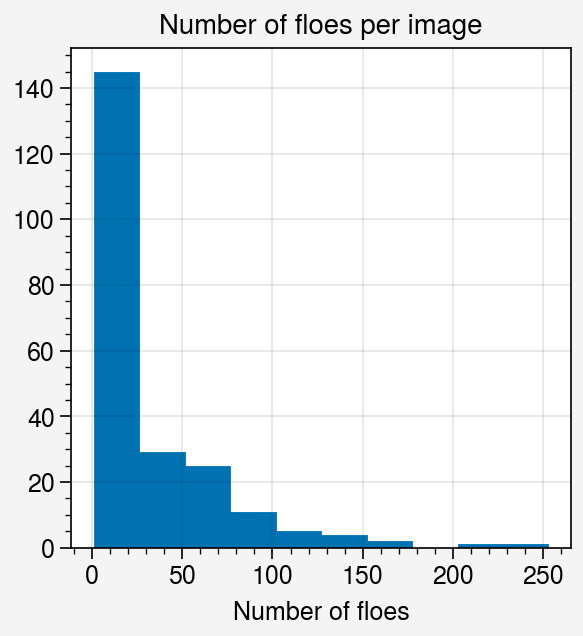

In [115]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.hist(data.groupby('case').count()['area'])
ax.format(xlabel='Number of floes', title='Number of floes per image')

In [116]:
# Plotting floe size distribution

In [125]:
# Check if case number is being formatted right in both
import pandas as pd
fsd_data = {}
for satellite in ['aqua', 'terra']:
    fsd_data[satellite] = {}
    for file in os.listdir('../data/validation_dataset/property_tables/' + satellite):
        if 'csv' in file:
            df = pd.read_csv('../data/validation_dataset/property_tables/' + satellite + '/' + file)
            if len(df) > 0:
                df['region'] = file.split('-')[1]
                df['date'] = pd.to_datetime(file.split('-')[2])
                fsd_data[satellite][file.split('-')[0]] = df


df_aqua_fsd = pd.concat(fsd_data['aqua']).reset_index()
df_terra_fsd = pd.concat(fsd_data['terra']).reset_index()
df_aqua_fsd.rename({'level_0': 'case_number'}, axis=1, inplace=True)
df_terra_fsd.rename({'level_0': 'case_number'}, axis=1, inplace=True)
df_terra_fsd.head()

,case_number,level_1,label,area,convex_area,centroid-0,centroid-1,perimeter,axis_major_length,axis_minor_length,case_number,region,date
0,117,0,1,450.0,469.0,32.755556,258.924444,79.012193,26.287795,22.047071,117,greenland_sea,2008-09-01
1,117,1,2,404.0,431.0,43.467822,142.304455,77.597980,26.683150,19.533545,117,greenland_sea,2008-09-01
2,117,2,3,90.0,92.0,47.477778,381.200000,33.313708,12.363690,9.456458,117,greenland_sea,2008-09-01
3,117,3,4,81.0,89.0,57.074074,112.246914,33.798990,12.657020,8.404632,117,greenland_sea,2008-09-01
4,117,4,5,26.0,28.0,54.961538,384.576923,17.071068,6.895378,4.838631,117,greenland_sea,2008-09-01


In [118]:
import numpy as np

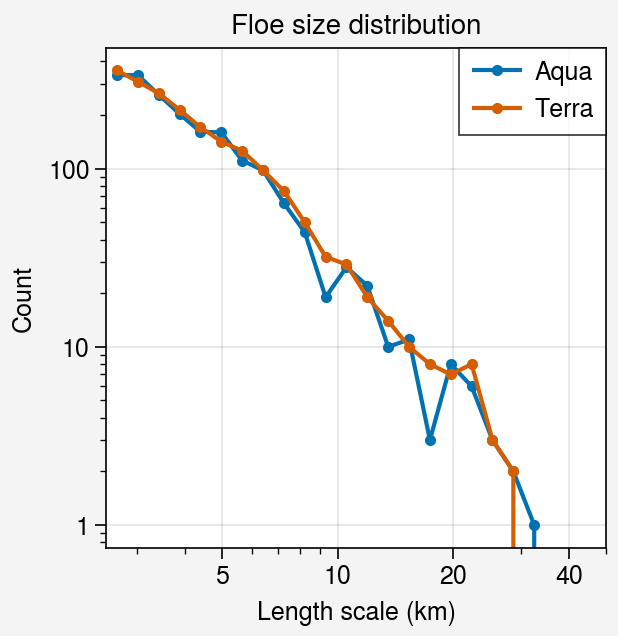

In [119]:
fig, ax = pplt.subplots()
for data, label in zip([df_aqua_fsd, df_terra_fsd], ['Aqua', 'Terra']):
    bins = np.logspace(1, np.log(np.sqrt(100)), 25)*0.25
    x, xb = np.histogram(np.sqrt(data['area'])*0.25, bins)
    
    ax.plot(0.5*(bins[:-1] + bins[1:]), x, marker='.', label=label)
    ax.format(yscale='log', xscale='log', ylabel='Count', xlocator=(1, 5, 10, 20, 40),
              xlim=(2.5, 50), xlabel='Length scale (km)', title='Floe size distribution')
ax.legend(loc='ur', ncols=1)

In [123]:
data = pd.concat([df_aqua_fsd, df_terra_fsd], axis=0)
print('Total number of floes in ground truth data:', data.shape[0])
print('Median number of floes per image: ', data.groupby('case_number').count().median()['area'])

Total number of floes in ground truth data: 6886


ValueError: Grouper for 'case_number' not 1-dimensional

In [121]:
regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
linestyles = {region: ls for region, ls in zip(regions.index,
                        ['-', '-.', '--', '-', '-.', '--', '-.', '-', '--'])}

baffin_bay 804
barents_kara_seas 215
beaufort_sea 517
bering_chukchi_seas 252
east_siberian_sea 305
greenland_sea 402
hudson_bay 429
laptev_sea 479
sea_of_okhostk 19
baffin_bay 813
barents_kara_seas 366
beaufort_sea 466
bering_chukchi_seas 322
east_siberian_sea 351
greenland_sea 404
hudson_bay 320
laptev_sea 409
sea_of_okhostk 13


/opt/miniconda3/envs/calval/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/opt/miniconda3/envs/calval/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


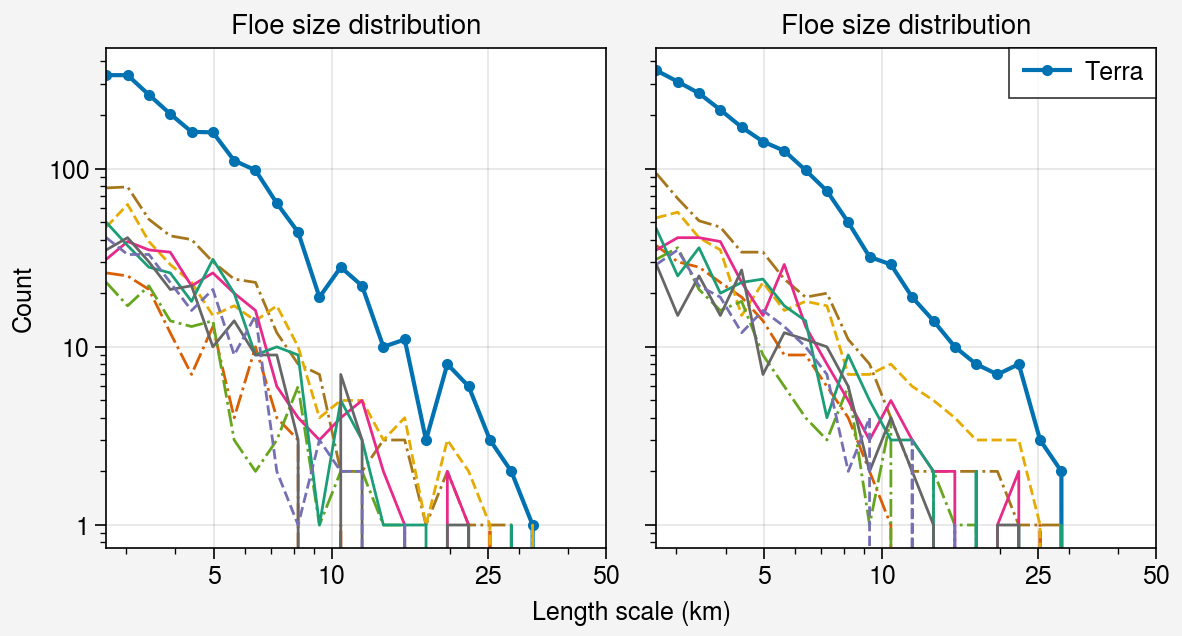

In [122]:
fig, axs = pplt.subplots(ncols=2)
for ax, data, label in zip(axs, [df_aqua_fsd, df_terra_fsd], ['Aqua', 'Terra']):
    bins = np.logspace(1, np.log(np.sqrt(100)), 25)*0.25
    x, xb = np.histogram(np.sqrt(data['area'])*0.25, bins)
    
    ax.plot(0.5*(bins[:-1] + bins[1:]), x, marker='.', label=label)
    for region, group in data.groupby('region'):
        bins = np.logspace(1, np.log(np.sqrt(100)), 25)*0.25
        x, xb = np.histogram(np.sqrt(group['area'])*0.25, bins)
        print(region, len(group))
        if len(group) > 100:
            ax.plot(0.5*(bins[:-1] + bins[1:]),
                x, marker='', label='', color=colors[region], ls=linestyles[region], lw=1)
        
    ax.format(yscale='log', xscale='log', ylabel='Count', xlocator=(1, 5, 10, 25, 50),
              xlim=(0, 50), xlabel='Length scale (km)', title='Floe size distribution')
ax.legend(loc='ur', ncols=1)